In [1]:
###Using linear regressoion to detect fraudulents activities. 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import preprocessing
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
train_iden_df = pd.read_csv("train_identity.csv")
train_trans_df = pd.read_csv("train_transaction.csv")
test_trans_df = pd.read_csv("test_transaction.csv")
test_iden_df = pd.read_csv("test_identity.csv")

In [5]:
# shape, this gives the dimensions of the dataset
print('Dimensions of the Train Identity set:',train_iden_df.shape)
print('Dimensions of the Train transaction set:',train_trans_df.shape)
print('Dimensions of the Test transaction set:',test_trans_df.shape)
print('Dimensions of the Test Identity set:',test_iden_df.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train transaction set: (590540, 394)
Dimensions of the Test transaction set: (506691, 393)
Dimensions of the Test Identity set: (141907, 41)


* Examine data

In [7]:
train_trans_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Checkign if all Transactions IDs from transaction dataset are in identity dataset
print(np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())))
print(np.sum(test_trans_df['TransactionID'].isin(test_iden_df['TransactionID'].unique())))

144233
141907


In [9]:
# Merge both the transaction and identity by left
train_df=pd.merge(train_trans_df,train_iden_df,how="left",on="TransactionID")
test_df=pd.merge(test_trans_df,test_iden_df,how="left",on="TransactionID")

In [10]:
# Print Shapes
print("Train Dataset shape: ", train_df.shape)
print("Test Dataset shape: ", test_df.shape)

Train Dataset shape:  (590540, 434)
Test Dataset shape:  (506691, 433)


#### Examine Merged Dataset for Train and Test

In [13]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Reduce Memory Usage

In [15]:
# This Step is done to reduce memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [18]:
# Using  above function to reduce memory usage for Train test df
train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (0.0% reduction)
Mem. usage decreased to 565.37 Mb (0.0% reduction)


In [17]:
# delete the 4 variables in order to reduce the memory issue
del train_iden_df
del train_trans_df
del test_trans_df
del test_iden_df

In [19]:
# Explore Categorical features
print('Training set:')
for col_name in train_df.columns:
    if train_df[col_name].dtypes == 'object' :
        unique_cat = len(train_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print("****************")
    
print('Test set:')
for col_name in test_df.columns:
    if test_df[col_name].dtypes == 'object' :
        unique_cat = len(test_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Training set:
Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 ca

##### Observe Basics statics using describe method

In [21]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3429904.25,3577539.0
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.00,1.0
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,11246620.00,15811131.0
TransactionAmt,590540.0,NaN,NaN,2.509766e-01,4.331250e+01,68.75,125.00,31936.0
card1,590540.0,9.898735e+03,4.901170e+03,1.000000e+03,6.019000e+03,9678.00,14184.00,18396.0
...,...,...,...,...,...,...,...,...
id_22,5169.0,inf,6.898438e+00,1.000000e+01,1.400000e+01,14.00,14.00,44.0
id_24,4747.0,1.282031e+01,2.371094e+00,1.100000e+01,1.100000e+01,11.00,15.00,26.0
id_25,5132.0,inf,9.743750e+01,1.000000e+02,3.210000e+02,321.00,371.00,548.0
id_26,5163.0,inf,3.209375e+01,1.000000e+02,1.190000e+02,149.00,169.00,216.0


In [17]:
cat_cols = [col for col in train_df.columns if train_df[col].dtype in ['object']]
train_df[cat_cols].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,...,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,...,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,...,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


Count Plot for Fraudulent vs legitimate transaction


0    96.500999
1     3.499001
Name: isFraud, dtype: float64

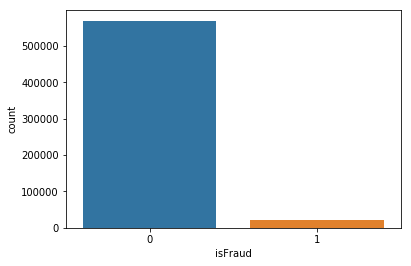

In [18]:
# Visualize target variable.(isFraud)
sns.countplot(train_df['isFraud'])
print("Count Plot for Fraudulent vs legitimate transaction") ## Imbalanced Dataset
train_df['isFraud'].value_counts(normalize=True) * 100

In [19]:
perc_fraud = len(train_df[train_df['isFraud']==1].index)*100/train_df.shape[0]
print("Percentage of Fradaulent records in dataset {:.2f}".format(perc_fraud) )

Percentage of Fradaulent records in dataset 3.50


#### Clean Data - Missing - NAN data

In [20]:
# Check missing data - Many Columns have more than 50% NA/Null records
def missing_data(df) :
    count = df.isnull().sum()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent], axis=1, keys = ['Count', 'Percent'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,0,0,0,0,0,8933,1565,1577,4259,...,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
Percent,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,...,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261,76.1557,79.9055
dtypes,int32,int8,int32,float16,object,int16,float16,float16,object,float16,...,object,float16,object,object,object,object,object,object,object,object


In [21]:
## WE will Drop columns with more 50% Null value.
null_percent = train_df.isnull().sum()/train_df.shape[0]*100

cols_to_drop = np.array(null_percent[null_percent > 50].index)

cols_to_drop

array(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9',
       'D12', 'D13', 'D14', 'M5', 'M7', 'M8', 'M9', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147',
       'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
       'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
       'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
       'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
       'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
       'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
       'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
       'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
       'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
       'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
       'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
       '

In [22]:
# Drop Columns (cols_to_drop) from train and test
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

In [23]:
print(train_df.shape)
print(test_df.shape)

(590540, 220)
(506691, 219)


In [24]:
### Fill NaNs

train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

#### Creating target (train_y) and feature variable (train_X)

In [25]:
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [26]:
# Label Encoding for categorical variables.
for f in train_X.columns:
    if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values) + list(test_df[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [27]:
## Create Base Model - LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predicting target for test data (test_df)
##### File : sample_submission.csv

In [28]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = logreg.predict_proba(test_df)[:,1]
submission.to_csv('Logreg_submission.csv')
submission.head()

,isFraud
TransactionID,
3663549,0.016161
3663550,0.018259
3663551,0.026362
3663552,0.029719
3663553,0.027054
